<a href="https://colab.research.google.com/github/ojuschauhan03/Crime-Detection/blob/main/UFC_dataset_Crime_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ucf-crime-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1710176%2F2799594%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240925%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240925T121628Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dcac8a9e440cfa34ba05424c535df6ab8cb04249e815a41985b59a9e93426f86c832c837d1aad8ca63d973fd3f9fbac97dbeab80adeaa0985fdba57db47b49124ba30fd027af367bea7c8957a87762f363d9b07b9ebd60a97552d28ffb3106b970c57238e53a8e0b7932bb814b307539753ff293cc0bfeeaabf0e45e6318eccc0b93bf444ddca4ff4eaa840b2c2ad1eb39c8e2530fddddbc37fd4d7b555b79b88de3eac10b09642a153b1e39c109089417517460ba42a53f3bd712c09882dcbed5e42c254054cc9b11c9d12d2e78aeb07b2a1b97517866c4f40b7af51edd8a2876c2f0ccf04bd7b52bc196a401795fb95236621115a70ec0c225d29f99d68bddf'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 11827280807 bytes downloaded
Downloaded and uncompressed: ucf-crime-dataset
Data source import complete.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.applications import DenseNet121
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D , Conv2D,Flatten
from tensorflow.keras.models import Sequential

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report


from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_dir = "../input/ucf-crime-dataset/Train"
test_dir = "../input/ucf-crime-dataset/Test"

SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 64
EPOCHS = 1
LR =  0.00003

In [ ]:
crime_types=os.listdir(train_dir)
n=len(crime_types)
print("Number of crime categories : ",n)

Number of crime categories :  14


Crimes have been catogarized in 14 different types.

In [ ]:
crimes={}
train=test=0
for clss in crime_types:
    num=len(os.listdir(os.path.join(train_dir,clss)))
    train+=num
    test+=len(os.listdir(os.path.join(test_dir,clss)))

    crimes[clss]=num

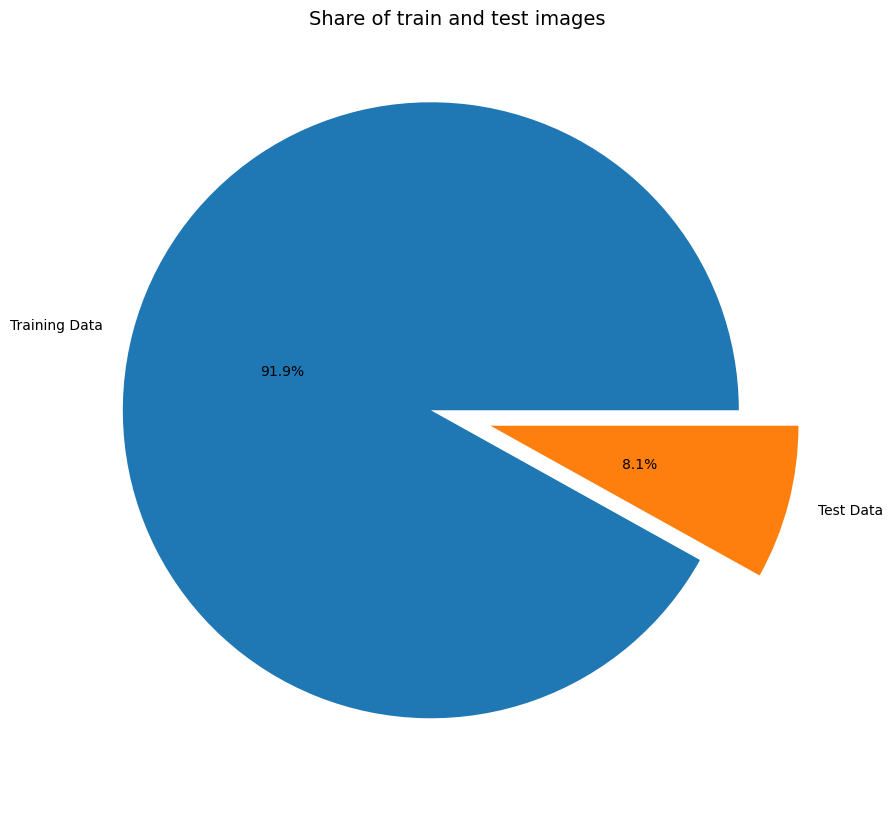

In [ ]:
plt.figure(figsize=(15, 10))
plt.pie(x=np.array([train,test]), autopct="%.1f%%", explode=[0.1, 0.1], labels=["Training Data", "Test Data"], pctdistance=0.5)
plt.title("Share of train and test images ", fontsize=14);

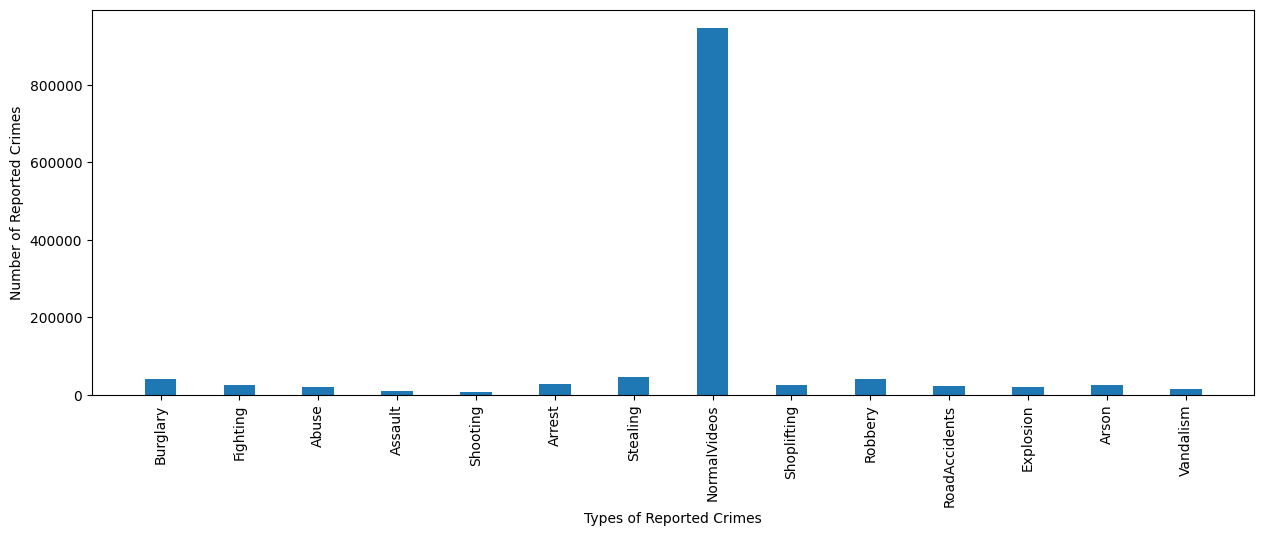

In [ ]:
plt.figure(figsize=(15,5))
plt.bar(list(crimes.keys()), list(crimes.values()), width=0.4,align="center" )
plt.xticks(rotation=90)

plt.xlabel("Types of Reported Crimes")
plt.ylabel("Number of Reported Crimes")
plt.show()

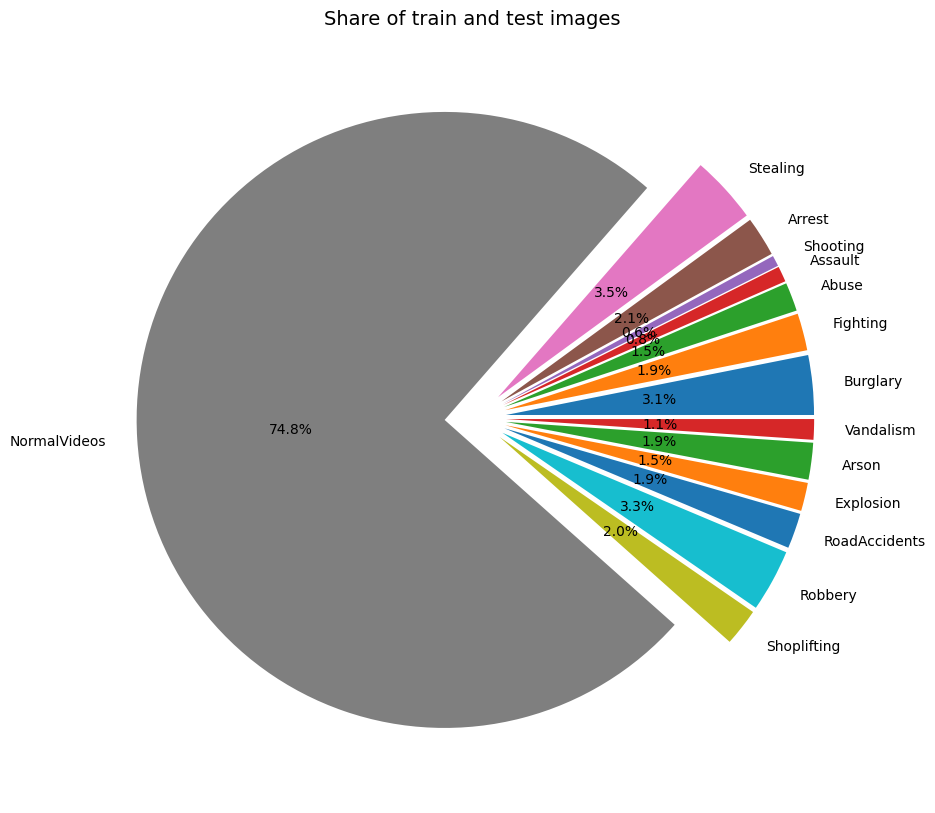

In [ ]:
plt.figure(figsize=(15,10))
plt.pie(x=np.array(list(crimes.values())), autopct="%.1f%%", explode=[0.1]*n,labels=list(crimes.keys()), pctdistance=0.5)
plt.title("Share of train and test images ", fontsize=14);

In [ ]:
IMG_WIDTH=64
IMG_HEIGHT=64

IMG_SHAPE=(IMG_HEIGHT,IMG_WIDTH)
seed=69

INPUT_SHAPE=(IMG_HEIGHT,IMG_WIDTH,3)

In [ ]:
train_set=image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="training",
)

val_set=image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="validation",
)

test_set=image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    class_names=None,
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=False,
    seed=seed,
)

Found 1266345 files belonging to 14 classes.
Using 1013076 files for training.
Found 1266345 files belonging to 14 classes.
Using 253269 files for validation.
Found 111308 files belonging to 14 classes.


In [ ]:
def transfer_learning():
    # Include the 'pooling' argument and set it to 'avg'
    base_model=DenseNet121(include_top=False,input_shape=INPUT_SHAPE,weights="imagenet", pooling='avg')

    thr=149
    for layers in base_model.layers[:thr]:
        layers.trainable=False

    for layers in base_model.layers[thr:]:
        layers.trainable=True

    return base_model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

def create_model():
    inputs = Input(shape=INPUT_SHAPE)
    x = transfer_learning()(inputs)
    x = Flatten()(x)

    x = Dense(256, activation="relu")(x)
    x = Dropout(0.2)(x)

    x = Dense(512, activation="relu")(x)
    x = Dropout(0.2)(x)

    x = Dense(1024, activation="relu")(x)

    outputs = Dense(14, activation="softmax", name="classification")(x) # Output layer with 14 units

    model = Model(inputs=inputs, outputs=outputs)

    model.summary()

    return model

In [ ]:
model=create_model()

model.compile(optimizer="adam",
                loss='categorical_crossentropy',metrics = [tf.keras.metrics.AUC()])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 1024)                │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification (Dense)               │ (None, 14)                  │          14,350 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,971,150 (30.41 MB)

 Trainable params: 6,386,894 (24.36 MB)

 Non-trainable params: 1,584,256 (6.04 MB)

In [ ]:
history = model.fit(x = train_set,validation_data=val_set,epochs = EPOCHS)

15830/15830 ━━━━━━━━━━━━━━━━━━━━ 1713s 102ms/step - auc_2: 0.9950 - loss: 0.2124 - val_auc_2: 0.9997 - val_loss: 0.0259


In [ ]:
y_true =  np.array([])

for x, y in test_set:
  y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis=-1)])

In [ ]:
y_pred=model.predict(test_set)

1740/1740 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step


In [ ]:
y_pred

array([[1.9101895e-02, 3.0304160e-02, 1.2828310e-02, ..., 1.4133133e-03,
        1.1552317e-02, 1.3808571e-01],
       [1.9287728e-02, 2.2723433e-02, 1.9591214e-02, ..., 9.9707721e-04,
        1.4427798e-02, 1.7828278e-01],
       [1.1705144e-02, 2.9572966e-02, 2.6659733e-02, ..., 7.1148231e-04,
        9.1405027e-03, 2.0627759e-02],
       ...,
       [1.2098517e-05, 1.2443219e-04, 9.4997551e-05, ..., 3.2525182e-05,
        1.9332886e-06, 2.2983847e-06],
       [2.3843933e-04, 9.2252815e-04, 1.3244729e-03, ..., 1.3662140e-03,
        5.8025918e-05, 7.1358263e-05],
       [3.3620081e-04, 1.1512238e-03, 2.5546120e-03, ..., 1.0695665e-03,
        1.3674452e-04, 1.1542617e-04]], dtype=float32)

In [ ]:
y_true

array([ 0.,  0.,  0., ..., 13., 13., 13.])

In [ ]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(crime_types):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

ROC AUC score: 0.8397440656832882


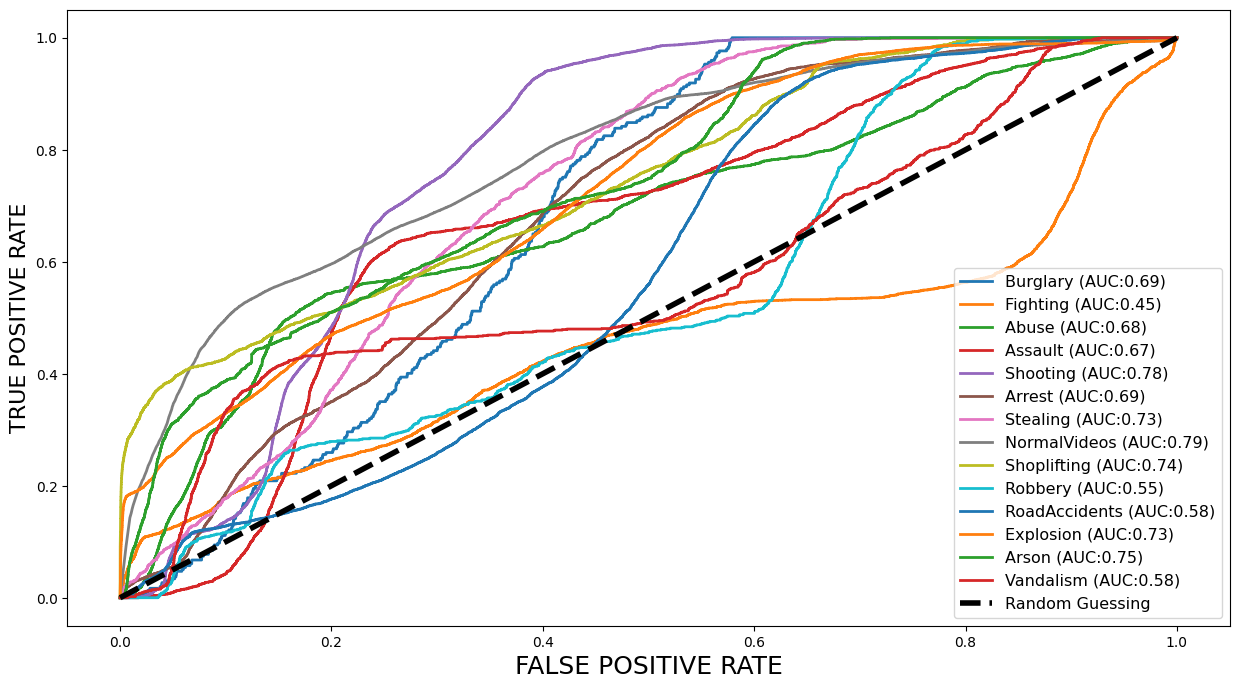

In [ ]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))


print('ROC AUC score:', multiclass_roc_auc_score(y_true , y_pred  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()